In [1]:
import pandas as pd
from google.colab import drive

drive.mount('/content/drive')

docs = pd.read_csv('/content/drive/MyDrive/datasets/provaxxers/provaxxers_processed.csv')
topics =  pd.read_csv('/content/drive/MyDrive/datasets/models/provaxxers_all_mpnet_base_v2_topics.csv')
docs = pd.concat([docs,topics], axis=1, ignore_index=False).drop(columns=["Unnamed: 0"])


favor = pd.read_json('/content/drive/MyDrive/datasets/provaxxers/rotulos/favor.json')
none = pd.read_json('/content/drive/MyDrive/datasets/provaxxers/rotulos/none.json')
favor = pd.DataFrame({'text':favor[0]})
none = pd.DataFrame({'text':none[0]})
favor['stance'] = 'favor'
none['stance']= 'none'
stances = pd.DataFrame()
stances = stances.append(favor)
stances = stances.append(none)

In [ ]:
favor = stances[stances['stance'] == 'favor'].sample(1500)
none = stances[stances['stance'] == 'none'].sample(1500)
stances = pd.DataFrame()
stances = stances.append(favor)
stances = stances.append(none)


stances['stance'].value_counts()

<AxesSubplot:xlabel='stance', ylabel='count'>

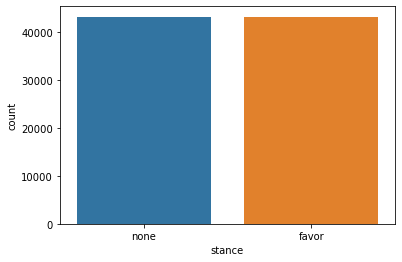

In [8]:
import seaborn as sns
from sklearn.utils import resample

mask = stances.stance=='favor'

df_favor = stances[mask]
df_none = stances[~mask]


df_downsample = resample(
    df_favor,
    replace=False,
    n_samples=len(df_none),
    random_state=42)

stances = pd.concat([df_none,df_downsample]).sort_index().reset_index().drop(columns=["index"]) 

sns.countplot(x=stances['stance'], label = 'count')

In [9]:
import sklearn
from sklearn.model_selection import train_test_split

train_data = stances
train_data = train_data.reset_index().drop(columns=["index"])
train_data["stance"] = train_data["stance"].replace(["favor", "none"],[0, 1])

X = train_data['text']
y = train_data['stance']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=333, test_size=0.3)

In [ ]:
def _get_last_layer_units_and_activation(num_classes):
    """Gets the # units and activation function for the last network layer.

    # Arguments
        num_classes: int, number of classes.

    # Returns
        units, activation values.
    """
    if num_classes == 2:
        activation = 'sigmoid'
        units = 1
    else:
        activation = 'softmax'
        units = num_classes
    return units, activation

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout


def mlp_model(layers, units, dropout_rate, input_shape, num_classes):
    """Creates an instance of a multi-layer perceptron model.

    # Arguments
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of the layers.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.

    # Returns
        An MLP model instance.
    """
    op_units, op_activation = _get_last_layer_units_and_activation(num_classes)
    model = Sequential()
    model.add(Dropout(rate=dropout_rate, input_shape=input_shape))

    for _ in range(layers-1):
        model.add(Dense(units=units, activation='relu'))
        model.add(Dropout(rate=dropout_rate))

    model.add(Dense(units=op_units, activation=op_activation))
    return model

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Vectorization parameters
# Range (inclusive) of n-gram sizes for tokenizing text.
NGRAM_RANGE = (1, 1)



# Whether text should be split into word or character n-grams.
# One of 'word', 'char'.
TOKEN_MODE = 'word'

# Minimum document/corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 2

kwargs = {
            'ngram_range': NGRAM_RANGE,  # Use 1-grams + 2-grams.
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE,  # Split text into word tokens.
            'min_df': MIN_DOCUMENT_FREQUENCY,
        }

vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(**kwargs)

X_train_vectorized = vectorizer.fit_transform(X_train).toarray()
X_test_vectorized = vectorizer.transform(X_test).toarray()

In [ ]:
#X_train_vectorized , X_test_vectorized = ngram_vectorize(X_train, X_test)
# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Select top 'k' of the vectorized features.
selector = SelectKBest(f_classif, k=min(TOP_K, X_train_vectorized.shape[1]))
selector.fit(X_train_vectorized, y_train)
X_train_vectorized = selector.transform(X_train_vectorized).astype('float64')
X_test_vectorized = selector.transform(X_test_vectorized).astype('float64')

In [ ]:
def get_num_classes(labels):
    """Gets the total number of classes.
    # Arguments
        labels: list, label values.
            There should be at lease one sample for values in the
            range (0, num_classes -1)
    # Returns
        int, total number of classes.
    # Raises
        ValueError: if any label value in the range(0, num_classes - 1)
            is missing or if number of classes is <= 1.
    """
    num_classes = max(labels) + 1
    missing_classes = [i for i in range(num_classes) if i not in labels]
    if len(missing_classes):
        raise ValueError('Missing samples with label value(s) '
                         '{missing_classes}. Please make sure you have '
                         'at least one sample for every label value '
                         'in the range(0, {max_class})'.format(
                            missing_classes=missing_classes,
                            max_class=num_classes - 1))

    if num_classes <= 1:
        raise ValueError('Invalid number of labels: {num_classes}.'
                         'Please make sure there are at least two classes '
                         'of samples'.format(num_classes=num_classes))
    return num_classes

In [ ]:
def train_mlp_model(data,
                      learning_rate=1e-3,
                      epochs=1000,
                      batch_size=128,
                      layers=2,
                      units=64,
                      dropout_rate=0.2):
    """Trains n-gram model on the given dataset.

    # Arguments
        data: tuples of training and test texts and labels.
        learning_rate: float, learning rate for training model.
        epochs: int, number of epochs.
        batch_size: int, number of samples per batch.
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of Dense layers in the model.
        dropout_rate: float: percentage of input to drop at Dropout layers.

    # Raises
        ValueError: If validation data has label values which were not seen
            in the training data.
    """
    # Get the data.
    (X_train, y_train), (X_test, y_test) = data

    # Verify that validation labels are in the same range as training labels.
    num_classes = get_num_classes(y_train)
    #num_classes = 2
    unexpected_labels = [v for v in y_test if v not in range(num_classes)]
    if len(unexpected_labels):
        raise ValueError('Unexpected label values found in the validation set:'
                         ' {unexpected_labels}. Please make sure that the '
                         'labels in the validation set are in the same range '
                         'as training labels.'.format(
                             unexpected_labels=unexpected_labels))

    model = mlp_model(layers=layers,
                                  units=units,
                                  dropout_rate=dropout_rate,
                                  input_shape=X_train.shape[1:],
                                  num_classes=num_classes)

    # Compile model with learning parameters.
    if num_classes == 2:
        loss = 'binary_crossentropy'
    else:
        loss = 'sparse_categorical_crossentropy'
    optimizer =  tf.keras.optimizers.Adam(learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

    # Create callback for early stopping on validation loss. If the loss does
    # not decrease in two consecutive tries, stop training.
    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=2)]


    # Train and validate model.
    history = model.fit(
            X_train,
            y_train,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(X_test, y_test),
            verbose=2,  # Logs once per epoch.
            batch_size=batch_size)
    # Print results.
    history = history.history
    print('Validation accuracy: {acc}, loss: {loss}'.format(
            acc=history['val_acc'][-1], loss=history['val_loss'][-1]))

    # Save model.
    model.save('axur_sms_classification.h5')
    #history['val_acc'][-1], history['val_loss'][-1]
    return model, history

In [ ]:
data = (X_train_vectorized,y_train),(X_test_vectorized,y_test)
mlp_model ,history = train_mlp_model(data)

In [ ]:
import matplotlib.pyplot as plt
#plt.style.use('ggplot')

def plot_history(history):
    acc = history['acc']
    val_acc = history['val_acc']
    loss = history['loss']
    val_loss = history['val_loss']
    x = range(1, len(acc) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.title('Training and validation loss')
    plt.legend()

In [ ]:
plot_history(history)